Данная работа нацелена на отработку практики использования библиотеки -pandas- etc. \
Многие решения не являются оптимальными. \
Задача, котороую я ставил в данной работе - найти зависимости, влияющие на распространение covid-19* и поиск ожидаемого горизонта завершения пика пандемии \
Для решения данной задачи были использованы гипотезы**: \
    - на распространение вируса влияет туристический рейтинг страны (доля в мировом объеме турпотока) \
    - доля страны в мировом торговом балансе влияет на рост локальной пандемии \
    - вес страны в мировой добыче/потреблении нефти влияет на рост локальной пандемии \
В качестве источников данных выступают открытые сайты и статистика Мирового банка (ссылки указаны в загрузчиках раздела). \
Данные по covid-19 : https://data.humdata.org/ \
\* - не все выводы являются окончательными и точными. Данные подгружаются в момент запуска данного Jupyter notebook! \
\** - не все данные могут отображаться корректно!

In [1]:
# !pip install html5lib
# ! pip install bs4
# ! pip install sys

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import re as re
import bs4 as bs
import lxml.html as html
import html5lib
import sys
import requests
import matplotlib.pyplot as plt

In [3]:
# Настройка графики
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 5]
# plt.rcParams['figure.figsize'] = (15, 5)  # Размер картинок
plt.rcParams['font.family'] = 'sans-serif' # Шрифт
plt.style.use('ggplot')  # Красивые графики

pd.options.display.max_rows = 10 # Количество строк?

## Covid,
#### данные по статистике погибших от  Института Хопкинса 

In [4]:
# # Парсим сайт со страницей по медалям и странам:
# # АДрес сайта:
# url = 'https://ru.wikipedia.org/wiki/%D0%9F%D0%B0%D0%BD%D0%B4%D0%B5%D0%BC%D0%B8%D1%8F_COVID-19'

# header = {
#   "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
#   "X-Requested-With": "XMLHttpRequest"
# }
# r = requests.get(url, headers=header)
# # создаем фрейм и делаем обертки для нужных колонок
# Deaths_raw = pd.read_html(url, header=0)[2].iloc[2:, [0,15]].rename(columns={ 'All-time countries statistics':'country', 'All-time countries statistics.15':'medals'})
# Deaths_raw = pd.read_html(url, header=0)
# Deaths_raw.head()

In [5]:
# загрузим данные о подтвержденных случаях covid-19
# источник данных - https://data.humdata.org/
url = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv'
Cases_raw = pd.read_csv(url)

# загружаем данные на текущую дату по количеству умерших:
Cases_raw = Cases_raw.rename(columns={'Country/Region': 'country'})
# удаляем провинции и штаты, так как нас интересует только в целом страна:
Cases_raw = Cases_raw.drop('Province/State', axis=1)
Cases_raw = Cases_raw.rename({'Lat':'X', 'Long':'Y'}, axis=1)

# суммируем строки по странам (убираем разделение на провинции и экстерритории)
data_c = Cases_raw.groupby('country').sum()
data_c = data_c.reset_index()

# Данные получаются из разных источников, поэтому названия стран не совпадают и их приходится корретировать в ручную
#!!! Переименовать страну, если не совпадает с другой таблицей
data_c.country[data_c.country == 'US'] = 'United States'
data_c.country[data_c.country == 'Korea, South'] = 'Korea Republic'
data_c.country[data_c.country == 'Czechia'] = 'Czech Republic'

data_c = data_c.pop(data_c.columns[-14])
data_c = pd.DataFrame(data_c)
data_c.shape

D:\Users\Admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Users\Admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Users\Admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(185, 1)

In [6]:
# источник данных - https://data.humdata.org/
url = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv'
Deaths_raw = pd.read_csv(url)

# загружаем данные на текущую дату по количеству умерших:
Deaths_raw = Deaths_raw.rename(columns={'Country/Region': 'country'})
# удаляем провинции и штаты, так как нас интересует только в целом страна:
Deaths_raw = Deaths_raw.drop('Province/State', axis=1)
Deaths_raw = Deaths_raw.rename({'Lat':'X', 'Long':'Y'}, axis=1)

# суммируем строки по странам (убираем разделение на провинции и экстерритории)
data_d = Deaths_raw.groupby('country').sum()
data_d = data_d.reset_index()

# Данные получаются из разных источников, поэтому названия стран не совпадают и их приходится корретировать в ручную
#!!! Переименовать страну, если не совпадает с другой таблицей
data_d.country[data_d.country == 'US'] = 'United States'
data_d.country[data_d.country == 'Korea, South'] = 'Korea Republic'
data_d.country[data_d.country == 'Czechia'] = 'Czech Republic'
data_c = data_c.fillna(0)
data_d['cases'] = data_c
data_d['rate_c'] = data_d.iloc[:,-2] / data_d.iloc[:,-1]
# переставим колонку Страна на первое место
# data_d = data_d.reindex(columns=([['country'], ['rate_c']] + list([a for a in data_d.columns if (a != 'country' or a != 'rate_c')]) ))
data_d = data_d.reindex(columns=(['country', 'rate_c'] + list([a for a in data_d.columns if  a != 'rate_c' and a != 'country']) ))
data_d = data_d.drop('cases', axis=1)
data_d.sort_values(by='rate_c', ascending=False).head(10)

D:\Users\Admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Users\Admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\Users\Admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,country,rate_c,X,Y,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
158,Sudan,0.857143,12.8628,30.2176,0,0,0,0,0,0,...,2,4,5,5,5,6,10,10,12,12
153,Somalia,0.666667,5.1521,46.1996,0,0,0,0,0,0,...,1,2,2,5,5,6,7,7,8,8
13,Bangladesh,0.504587,23.6850,90.3563,0,0,0,0,0,0,...,34,39,46,50,60,75,84,91,101,110
164,Tanzania,0.400000,-6.3690,34.8888,0,0,0,0,0,0,...,3,3,3,4,4,5,5,7,10,10
122,Nicaragua,0.333333,12.8654,-85.2072,0,0,0,0,0,0,...,1,1,1,1,1,1,2,2,2,2
28,Burundi,0.333333,-3.3731,29.9189,0,0,0,0,0,0,...,0,1,1,1,1,1,1,1,1,1
175,United Kingdom,0.282689,270.0299,-482.9247,0,0,0,0,0,0,...,10629,11347,12129,12894,13759,14607,15498,16095,16550,17378
184,Zimbabwe,0.272727,-20.0000,30.0000,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
97,Liberia,0.258065,6.4281,-9.4295,0,0,0,0,0,0,...,5,6,6,6,6,7,7,8,8,8
16,Belgium,0.256292,50.8333,4.0000,0,0,0,0,0,0,...,3600,3903,4157,4440,4857,5163,5453,5683,5828,5998


In [7]:
data_d.shape

(185, 95)

In [8]:
# проверим наличие повторов по стране
data_d[data_d.country == 'United Kingdom']

,country,rate_c,X,Y,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
175,United Kingdom,0.282689,270.0299,-482.9247,0,0,0,0,0,0,...,10629,11347,12129,12894,13759,14607,15498,16095,16550,17378


In [9]:
data_d.head()

,country,rate_c,X,Y,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,Afghanistan,0.081081,33.0000,65.0000,0,0,0,0,0,0,...,18,21,23,25,30,30,30,33,36,36
1,Albania,0.065000,41.1533,20.1683,0,0,0,0,0,0,...,23,23,24,25,26,26,26,26,26,26
2,Algeria,0.249364,28.0339,1.6596,0,0,0,0,0,0,...,293,313,326,336,348,364,367,375,384,392
3,Andorra,0.065603,42.5063,1.5218,0,0,0,0,0,0,...,29,29,31,33,33,35,35,36,37,37
4,Angola,0.105263,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


#### Посмотрим на графики по датам для топ-10 (страны, где макс по потерям от COVID)

In [10]:
# Топ-10
# Ось Х - дата
# Ось У - количество потерь
data_top = data_d.sort_values(by=data_d.columns[-1], ascending=False)
data_top.head()

,country,rate_c,X,Y,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
171,United States,0.104618,37.0902,-95.7129,0,0,0,0,0,0,...,22029,23538,25843,28338,32930,36787,38664,40661,42094,44845
84,Italy,0.176787,43.0000,12.0000,0,0,0,0,0,0,...,19899,20465,21067,21645,22170,22745,23227,23660,24114,24648
156,Spain,0.143584,40.0000,-4.0000,0,0,0,0,0,0,...,17209,17756,18056,18708,19315,20002,20043,20453,20852,21282
61,France,0.250780,91.3624,59.7192,0,0,0,0,0,0,...,14412,14986,15748,17188,17941,18703,19345,19744,20292,20829
175,United Kingdom,0.282689,270.0299,-482.9247,0,0,0,0,0,0,...,10629,11347,12129,12894,13759,14607,15498,16095,16550,17378


In [11]:

# матрица значений для построения графика и вычисления логистической прогрессии по ТОП-10
data_graf = pd.DataFrame(data = data_top.iloc[:10,4:])
# список Топ-10 стран по потерям
country_name = data_top.iloc[:10,0]
data_graf.shape

(10, 91)

In [100]:
# для удобства анализа прологарифмируем значения по столбцам
data_graf_log = np.log(data_graf.iloc[:,:] > 0) / 10
# data_graf_log = np.log(data_graf.iloc[:,:]) / np.log(data_graf.iloc[:,:].max())

D:\Users\Admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [101]:
data_graf_log.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
171,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
156,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


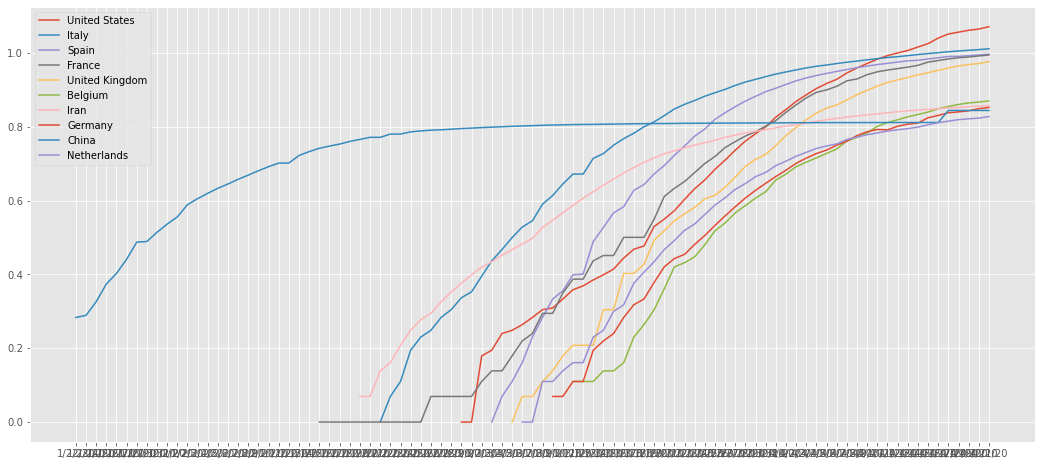

In [13]:
# выведем график по топ-10 стран по потерям за весь период наблюдений
x = data_graf_log.columns
y = data_graf_log
plt.figure(figsize=(18, 8))
for i in range(len(y)):
    plt.plot(x, data_graf_log.iloc[i, :], label=country_name)

plt.legend(country_name)
# plt.xlabel('Score', size = 20)
# plt.ylabel('log_death', size = 20)

Text(0, 0.5, 'log_death')

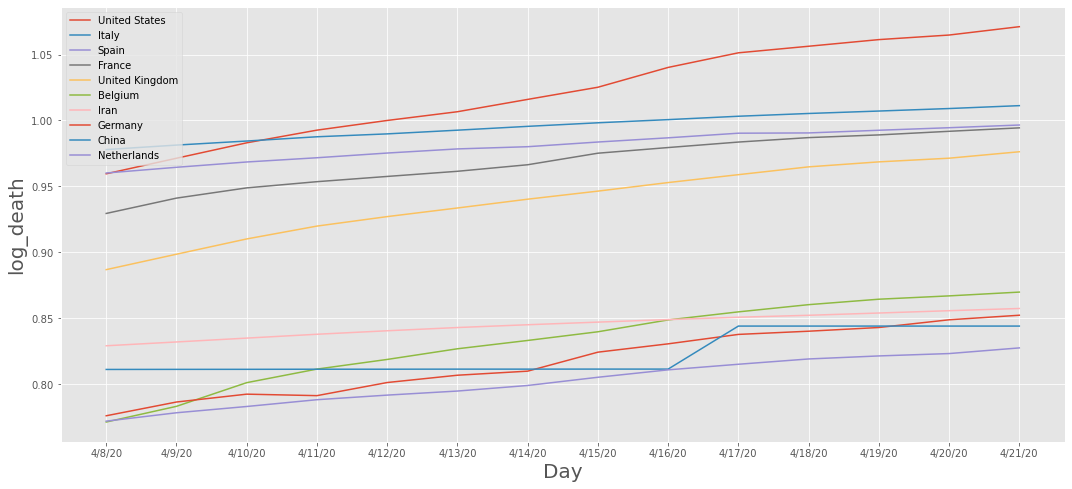

In [14]:
# выведем график по топ-10 стран по потерям за 14 дней до текущей даты
x = data_graf_log.columns[-14:]
y = data_graf_log.iloc[:,-14:]
plt.figure(figsize=(18, 8))
for i in range(len(y)):
    plt.plot(x, data_graf_log.iloc[i, -14:], label=country_name)

plt.legend(country_name)
plt.xlabel('Day', size = 20)
plt.ylabel('log_death', size = 20)

Графики выше показывают как выходят на "плато" страны. Характерный график у Китая - он уже на стабильном плато. \
Все, кроме США - только подходят к плато. \
Ниже посмотрим на страны, у которых пока уровень потерь невысок, однако, может быть из-за того, что страна только "входит" в процесс

У нас есть матрицы:
    - самые высокие потери =Топ-10
    - самые быстрорастущие
    - замедляющиеся или на плато

### Посмотрим на производную роста потерь

In [15]:
data_rate_ = data_d.iloc[:,:]

data_rate_ = data_rate_.to_numpy()
data_rate_summary = []
tmp = []
# print(data_d.shape, data_rate_[0,0], len(data_rate_), len(data_rate_[0,]))
for i in range(len(data_rate_)):
    for j in range(3, len(data_rate_[0,])-1):
        if data_rate_[i, j] == 0 or data_rate_[i, j+1] == 0:
            rate_=0
        else:
            rate_ = (data_rate_[i, j+1] - data_rate_[i, j]) / data_rate_[i, j+1]

        data_rate_summary.append(rate_)
data_rate_summary = np.array(data_rate_summary)
tmp = data_rate_summary.reshape(185,-1)
# сформируем фрейм с данным:
data_rate_summary = pd.DataFrame(tmp)
# добавим столбец с количеством умерших
data_rate_summary['num_cumulative_count'] = data_d.iloc[:,-1]
data_rate_summary['country'] = data_rate_[:,0]
# переставим колонку Страна на первое место
data_rate_summary = data_rate_summary.reindex(columns=(['country'] + list([a for a in data_rate_summary.columns if a != 'country']) ))

data_rate_summary.head()

,country,0,1,2,3,4,5,6,7,8,...,82,83,84,85,86,87,88,89,90,num_cumulative_count
0,Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142857,0.086957,0.080000,0.166667,0.000000,0.000000,0.090909,0.083333,0.000000,36
1,Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.041667,0.040000,0.038462,0.000000,0.000000,0.000000,0.000000,0.000000,26
2,Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.063898,0.039877,0.029762,0.034483,0.043956,0.008174,0.021333,0.023438,0.020408,392
3,Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.064516,0.060606,0.000000,0.057143,0.000000,0.027778,0.027027,0.000000,37
4,Angola,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2


In [98]:
data_d.iloc[:,-10:]

,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,18,21,23,25,30,30,30,33,36,36
1,23,23,24,25,26,26,26,26,26,26
2,293,313,326,336,348,364,367,375,384,392
3,29,29,31,33,33,35,35,36,37,37
4,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...
180,2,2,2,2,2,2,2,3,3,4
181,0,0,0,0,0,0,0,0,0,0
182,0,0,0,0,0,0,0,0,0,0
183,2,2,2,2,2,2,2,3,3,3


In [16]:
# отсортируем страны по суммарному количеству умерших на текущую дату
data_rate_summary = data_rate_summary.sort_values(by = data_rate_summary.columns[-1], ascending=False).head(20)
# теперь удалим столбец "потери"
data_rate_summary = data_rate_summary.drop(['num_cumulative_count'], axis=1)
# теперь отсортируем по коэффициенту роста погибших
data_rate_summary = data_rate_summary.sort_values(by =  data_rate_summary.columns[-1], ascending=False).head(10)
data_rate_summary.head(10)

,country,0,1,2,3,4,5,6,7,8,...,81,82,83,84,85,86,87,88,89,90
160,Sweden,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013348,0.021763,0.110358,0.141313,0.097524,0.047857,0.073461,0.018831,0.025316,0.104816
32,Canada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.084034,0.083440,0.133482,0.106362,0.199682,0.071640,0.032166,0.104926,0.093913,0.095912
78,India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.129909,0.075419,0.089059,0.029630,0.095982,0.078189,0.067179,0.067979,0.055743,0.082171
171,United States,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.070725,0.064109,0.089192,0.088044,0.139447,0.104847,0.048546,0.049113,0.034043,0.061345
82,Ireland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.041916,0.084932,0.100985,0.085586,0.086420,0.083019,0.071804,0.063934,0.112082,0.058904
23,Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.080948,0.079066,0.133159,0.117512,0.097713,0.101355,0.090484,0.043867,0.048319,0.056184
170,Turkey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.080968,0.075617,0.076265,0.075758,0.076080,0.071227,0.064021,0.062965,0.057477,0.052678
175,United Kingdom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.069339,0.063277,0.064474,0.059330,0.062868,0.058054,0.057491,0.037092,0.027492,0.047646
79,Indonesia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.123324,0.065163,0.130719,0.021322,0.054435,0.046154,0.028037,0.080756,0.013559,0.042208
120,Netherlands,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.034219,0.030357,0.041286,0.060413,0.054704,0.041487,0.039303,0.022721,0.017800,0.041995


### График "Рост погибших за период наблюдений"

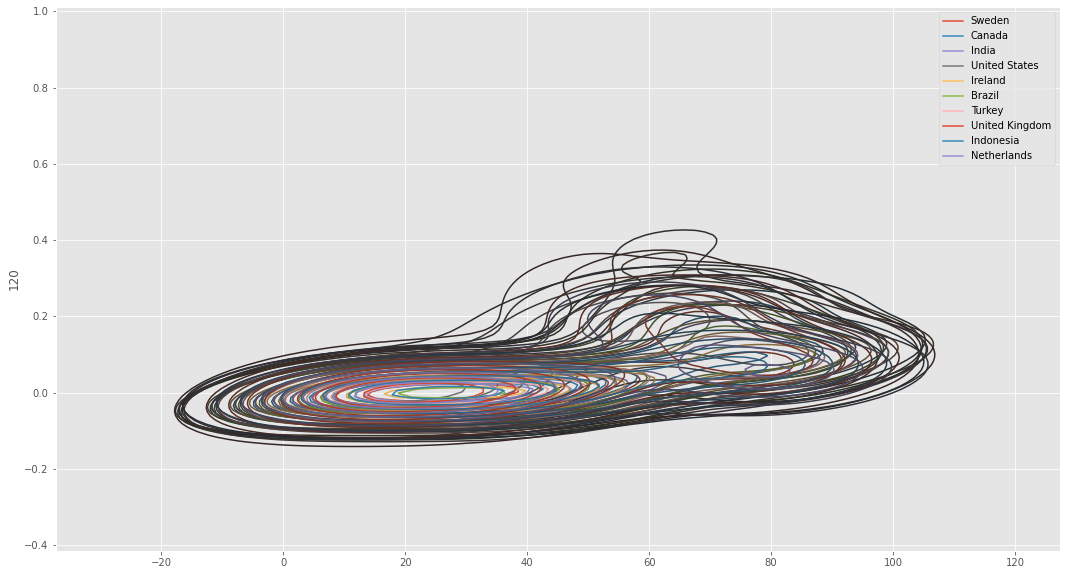

In [17]:
country_name = data_rate_summary.iloc[:,0]
xx = data_rate_summary.columns[1:]
yy = data_rate_summary
plt.figure(figsize=(18, 10))
for i in range(len(yy)):
#     plt.kdeplot(x, data_rate_summary.iloc[i, 1:], label=country_name)
    sns.kdeplot(xx, data_rate_summary.iloc[i, 1:], label=country_name)
plt.legend(country_name)

Text(0, 0.5, 'Rate_death')

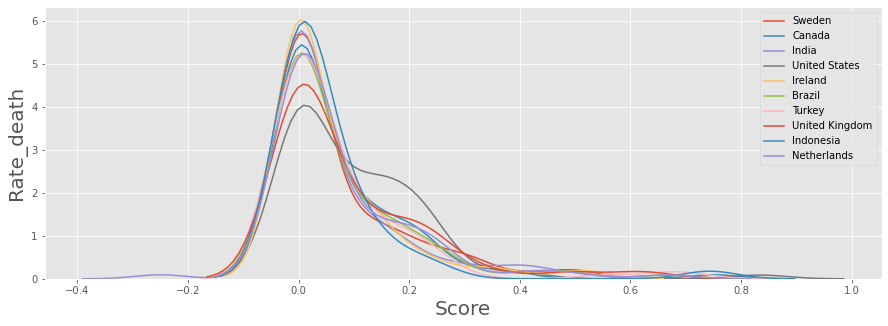

In [18]:
for i in range(len(yy)):
#     plt.kdeplot(x, data_rate_summary.iloc[i, 1:], label=country_name)
    sns.kdeplot(data_rate_summary.iloc[i, 1:], label=country_name)
plt.legend(country_name)
plt.xlabel('Score', size = 20)
plt.ylabel('Rate_death', size = 20)

Text(0, 0.5, 'Rate_death')

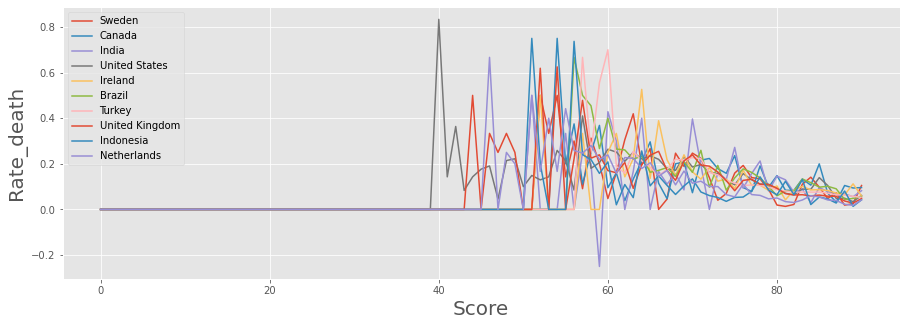

In [19]:
for i in range(len(yy)):
#     plt.kdeplot(x, data_rate_summary.iloc[i, 1:], label=country_name)
    plt.plot(data_rate_summary.iloc[i, 1:], label=country_name)
plt.legend(country_name)
plt.xlabel('Score', size = 20)
plt.ylabel('Rate_death', size = 20)

Text(0, 0.5, 'Rate_death')

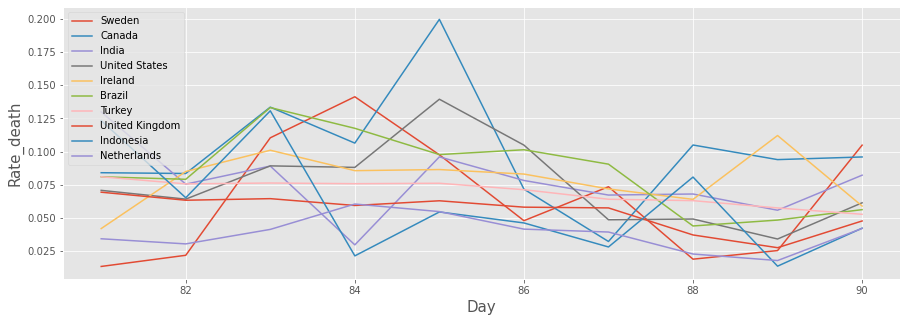

In [20]:
# последняя декада наблюдений
country_name = data_rate_summary.iloc[:,0]
xx = data_rate_summary.columns[-10:]
yy = data_rate_summary.iloc[:,-10:]

for i in range(len(yy)):
#     plt.kdeplot(x, data_rate_summary.iloc[i, 1:], label=country_name)
    plt.plot(data_rate_summary.iloc[i, -10:], label=country_name)
plt.legend(country_name)
plt.xlabel('Day', size = 15)
plt.ylabel('Rate_death', size = 15)

In [97]:
data_rate_summary.iloc[:, -10:]

,81,82,83,84,85,86,87,88,89,90
160,0.013348,0.021763,0.110358,0.141313,0.097524,0.047857,0.073461,0.018831,0.025316,0.104816
32,0.084034,0.083440,0.133482,0.106362,0.199682,0.071640,0.032166,0.104926,0.093913,0.095912
78,0.129909,0.075419,0.089059,0.029630,0.095982,0.078189,0.067179,0.067979,0.055743,0.082171
171,0.070725,0.064109,0.089192,0.088044,0.139447,0.104847,0.048546,0.049113,0.034043,0.061345
82,0.041916,0.084932,0.100985,0.085586,0.086420,0.083019,0.071804,0.063934,0.112082,0.058904
23,0.080948,0.079066,0.133159,0.117512,0.097713,0.101355,0.090484,0.043867,0.048319,0.056184
170,0.080968,0.075617,0.076265,0.075758,0.076080,0.071227,0.064021,0.062965,0.057477,0.052678
175,0.069339,0.063277,0.064474,0.059330,0.062868,0.058054,0.057491,0.037092,0.027492,0.047646
79,0.123324,0.065163,0.130719,0.021322,0.054435,0.046154,0.028037,0.080756,0.013559,0.042208
120,0.034219,0.030357,0.041286,0.060413,0.054704,0.041487,0.039303,0.022721,0.017800,0.041995


In [21]:
data_d.head()

,country,rate_c,X,Y,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20
0,Afghanistan,0.081081,33.0000,65.0000,0,0,0,0,0,0,...,18,21,23,25,30,30,30,33,36,36
1,Albania,0.065000,41.1533,20.1683,0,0,0,0,0,0,...,23,23,24,25,26,26,26,26,26,26
2,Algeria,0.249364,28.0339,1.6596,0,0,0,0,0,0,...,293,313,326,336,348,364,367,375,384,392
3,Andorra,0.065603,42.5063,1.5218,0,0,0,0,0,0,...,29,29,31,33,33,35,35,36,37,37
4,Angola,0.105263,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [22]:
# data_d.iloc[:,0:-1]
data_columns = data_d.iloc[:,0]
result = pd.DataFrame(data=data_d.iloc[:,[0,1,-1]])
result = result.rename(columns={result.columns[-1]: 'max_d'})
# data_dd['country'] = data_d.iloc[1:,0]
# data_dd['max_num_deatch'] = data_d.iloc[1:,-1]
# data_dd
result.sort_values(by = 'rate_c', ascending = False).head(15)

,country,rate_c,max_d
158,Sudan,0.857143,12
153,Somalia,0.666667,8
13,Bangladesh,0.504587,110
164,Tanzania,0.400000,10
122,Nicaragua,0.333333,2
...,...,...,...
111,Mexico,0.255655,712
61,France,0.250780,20829
63,Gambia,0.250000,1
104,Malawi,0.250000,2


# Olymp

#### спарсим данные с МОК по всем странам и получим таблицу завоеванных медалей по каждой стране с 1896 по 2018 гг

In [23]:
# Парсим сайт со страницей по медалям и странам:
# АДрес сайта:
url = 'http://olympanalyt.com/OlympAnalytics.php?param_pagetype=MedalsByCountries'
# создаем фрейм и делаем обертки для нужных колонок
olympic = pd.read_html(url, header=0)[2].iloc[2:, [0,15]].rename(columns={ 'All-time countries statistics':'country', 'All-time countries statistics.15':'medals'})
# print(olympic.sort_values('medals'))
olympic = olympic.reset_index(drop=True)
olympic['name_country'] = olympic['country'].str.split("\ \(").str.get(0)
olympic = olympic.drop('country', axis=1) 
olympic = olympic.rename({'name_country':'country'}, axis=1)
olympic['medals_int'] = olympic['medals'].astype(int)
olympic = olympic.drop(['medals'], axis=1)
olympic = olympic.rename({'medals_int': 'medals'}, axis=1)
olympic.head(5)

,country,medals
0,Afghanistan,2
1,Albania,0
2,Algeria,17
3,American Samoa,0
4,Andorra,0


### Почистим названия стран , 
#### которые менялись и суммируем общее значение медалей по каждой строке (бывш. названия стран) не менее 1% от общего значения

In [24]:
(olympic[olympic.country == 'Republic of China'])

,country,medals
42,Republic of China,0


In [25]:
rf = (olympic.iloc[165:170, 1]).sum()
olympic.loc[olympic.country == 'Russian Federation'] = ['Russian Federation', rf]
# удалим Гон-Конг и Республика Китай - их значения =>0
olympic = olympic.drop([166, 167, 168, 169, 42, 89], axis=0).reset_index(drop=True)
olympic.country[olympic.country == 'Russian Federation'] = 'Russia'

ch = (olympic.iloc[53:56, 1]).sum()
olympic.loc[olympic.country == 'Czech Republic'] = ['Czech Republic', ch]
olympic = olympic.drop([54, 55], axis=0).reset_index(drop=True)

ge = (olympic.iloc[71:76, 1]).sum()
olympic.loc[olympic.country == 'Germany'] = ['Germany', ge]
olympic = olympic.drop([72, 73, 74, 75], axis=0).reset_index(drop=True)

olympic = olympic.drop([138], axis=0).reset_index(drop=True)

D:\Users\Admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [26]:
# проверяем на ошибки и повторы
(olympic[olympic.country == 'Republic of China'])

,country,medals


Результат вверху =None - значит все норм.

### Посчитаем
#### вес страны в общем количестве медалей

In [27]:
olympic.tail()

,country,medals
214,Zimbabwe,8
215,Independent Olympic Athletes,2
216,Mixed Team,17
217,Refugee Olympic Team,0
218,Total,18853


In [28]:
total = olympic.medals.max()
olympic['rate_m'] = round((olympic['medals'] / total), 3)

In [29]:
olympic = olympic.drop('medals', axis=1)
olympic = olympic.drop([215,216,217,218], axis=0)

#### Финальный список по странам -  в долях от общего кол-ва медалей за период 1896-2018гг

In [30]:
# проверка значений рейтинга
olympic.sort_values('rate_m', ascending=False).head(5)

,country,rate_m
202,United States,0.150
156,Russia,0.101
70,Germany,0.048
72,Great Britain,0.047
66,France,0.045


In [31]:
# # проверка на максимум
# olympic.rate_m.max()

### Connect Olymp

In [32]:
left = result
right = olympic
result = pd.merge(right, left, on='country')
# переставим на первое место название страны
result = result.reindex(columns=(['country'] + list([a for a in result.columns if a != 'country']) ))
result.sort_values('rate_m', ascending=False)
# result

,country,rate_m,rate_c,max_d
161,United States,0.150,0.104618,44845
126,Russia,0.101,0.052583,456
57,Germany,0.048,0.044423,5033
53,France,0.045,0.250780,20829
74,Italy,0.037,0.176787,24648
...,...,...,...,...
63,Guyana,0.000,0.189189,7
62,Guinea-Bissau,0.000,0.000000,0
61,Guinea,0.000,0.036585,6
60,Guatemala,0.000,0.080460,7


In [33]:
result.reset_index(drop=True)

,country,rate_m,rate_c,max_d
0,Afghanistan,0.000,0.081081,36
1,Albania,0.000,0.065000,26
2,Algeria,0.001,0.249364,392
3,Andorra,0.000,0.065603,37
4,Angola,0.000,0.105263,2
...,...,...,...,...
164,Venezuela,0.001,0.059880,10
165,Vietnam,0.000,0.000000,0
166,Yemen,0.000,NaN,0
167,Zambia,0.000,0.076923,3


## Economics
#### экономические данные: доля страны в мировом ВП

In [34]:
# Парсим сайт со страницей по медалям и странам:
# АДрес сайта:
url = 'http://wdi.worldbank.org/table/WV.1'
# создаем фрейм и делаем обертки для нужных фичей
economic = pd.read_html(url)[2].iloc[0:,0:5]
economic = economic.rename({0:'country', 1:'popul', 2:'area', 3:'pop_density', 4:'gni'}, axis=1)
# удаляем ненужные строки
economic = economic.drop([216,217,218,219,220,221,222,223,224,225,226], axis=0)
economic = economic.reset_index(drop=True)
economic.country[economic.country == 'Russian Federation'] = 'Russia'
economic.country[economic.country == 'Kyrgyz Republic'] = 'Kyrgyzstan'
economic.country[economic.country == 'Korea, Dem. Peopleâs Rep.'] = 'Korea Republic'
economic.country[economic.country == 'Iran, Islamic Rep.'] = 'Iran'
economic.country[economic.country == 'Congo, Dem. Rep.'] = 'Congo DR'
economic.country[economic.country == 'Congo, Rep.'] = 'Congo'
economic.country[economic.country == 'Hong Kong SAR, China'] = 'Hong Kong'
# заемняем пустые значения на 0:
economic.popul[economic.popul=='..'] = 0
economic.area[economic.area=='..'] = 0
economic.pop_density[economic.pop_density=='..'] = 0
economic.gni[economic.gni=='..'] = 0

# преобразуем данные в формат float:
economic['popul_int'] = economic['popul'].astype(float)
economic['area_int'] = economic['area'].astype(float)
economic['pop_density_int'] = economic['pop_density'].astype(float)
economic['gni_int'] = economic['gni'].astype(float)
economic = economic.drop(['popul', 'area', 'pop_density', 'gni'], axis=1)
# найдем максимумы для подсчета весов - это итоговые строки по указанным параметрам, потом м их удаляем:
pop_max = economic.popul_int.max()
area_max = economic.area_int.max()
den_max = economic.pop_density_int.max()
gni_max = economic.gni_int.max()
# посчитаем веса по каждой стране и по каждому критерию
economic['rate_pop'] = round((economic['popul_int'] / pop_max), 3)
economic['rate_area'] = round((economic['area_int'] / area_max), 3)
economic['rate_den'] = round((economic['pop_density_int'] / den_max), 3)
economic['rate_gni'] = round((economic['gni_int'] / gni_max), 3)
# удаляем ненужные больше столбцы и строки
economic = economic.drop([215], axis=0)
economic = economic.drop(['popul_int','area_int','pop_density_int','gni_int'], axis=1)
economic = economic.drop([41], axis=0)

economic.head()

,country,rate_pop,rate_area,rate_den,rate_gni
0,Afghanistan,0.005,0.005,0.003,0.000
1,Albania,0.000,0.000,0.005,0.000
2,Algeria,0.006,0.018,0.001,0.002
3,American Samoa,0.000,0.000,0.013,0.000
4,Andorra,0.000,0.000,0.008,0.000


In [35]:
economic.shape

(214, 5)

#### Connect Economic

In [36]:
left = result
right = economic
result = pd.merge(right, left, on='country')
result.head()

,country,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,max_d
0,Afghanistan,0.005,0.005,0.003,0.000,0.000,0.081081,36
1,Albania,0.000,0.000,0.005,0.000,0.000,0.065000,26
2,Algeria,0.006,0.018,0.001,0.002,0.001,0.249364,392
3,Andorra,0.000,0.000,0.008,0.000,0.000,0.065603,37
4,Angola,0.004,0.009,0.001,0.001,0.000,0.105263,2


In [37]:
# переставим на первое место название страны
# result = result.reindex(columns=(['country'] + list([a for a in result.columns if a != 'country']) ))
# result.sort_values('rate_gni', ascending=False).head(10)

## Tourism
#### количество входяших и исходяших в млн. на 2017г.

In [38]:
# Парсим сайт со страницей по медалям и странам:
# АДрес сайта:
url = 'http://wdi.worldbank.org/table/6.14'
# создаем фрейм и делаем обертки для нужных колонок
travel = pd.read_html(url)[2].iloc[0:,[0,2,4]]
travel = travel.rename({0 : 'country', 2 : 't_in', 4 : 't_out'}, axis=1)
travel = travel.drop([215,216,217,218,219,220,221,222,223,224,225])

travel.country[travel.country == 'Russian Federation'] = 'Russia'
travel.country[travel.country == 'Kyrgyz Republic'] = 'Kyrgyzstan'
travel.country[travel.country == 'Korea, Dem. Peopleâs Rep.'] = 'Korea Republic'
travel.country[travel.country == 'Iran, Islamic Rep.'] = 'Iran'
travel.country[travel.country == 'Congo, Dem. Rep.'] = 'Congo DR'
travel.country[travel.country == 'Congo, Rep.'] = 'Congo'
travel.country[travel.country == 'Hong Kong SAR, China'] = 'Hong Kong'

travel.t_in[travel.t_in=='..'] = 0
travel.t_out[travel.t_out=='..'] = 0

travel['t_in_int'] = travel['t_in'].astype(int)
travel['t_out_int'] = travel['t_out'].astype(int)
travel = travel.drop(['t_in', 't_out'], axis=1)

# найдем максимумы для подсчета весов:
# удаляем строку с суммарным оборотом:
travel = travel.drop([214], axis=0)
com_in_max = travel.t_in_int.sum()
com_out_max = travel.t_out_int.sum()

# посчитаем веса по каждой стране и по каждому критерию
travel['rate_t_in'] = round((travel['t_in_int'] / com_in_max), 3)
travel['rate_t_out'] = round((travel['t_out_int'] / com_out_max), 3)

# удаляем ненужные больше столбцы и строки
travel = travel.drop(['t_in_int','t_out_int'], axis=1)

travel.sort_values('rate_t_out', ascending=False).head(10)

,country,rate_t_in,rate_t_out
40,China,0.046,0.126
73,Germany,0.028,0.082
41,Hong Kong,0.021,0.081
203,United States,0.058,0.077
202,United Kingdom,0.028,0.063
157,Russia,0.018,0.035
34,Canada,0.016,0.029
94,Italy,0.044,0.028
68,France,0.065,0.026
200,Ukraine,0.011,0.023


In [39]:
travel.sort_values(by='rate_t_in', ascending=False).head(10)

,country,rate_t_in,rate_t_out
68,France,0.065,0.026
175,Spain,0.062,0.015
203,United States,0.058,0.077
40,China,0.046,0.126
94,Italy,0.044,0.028
125,Mexico,0.030,0.017
73,Germany,0.028,0.082
195,Turkey,0.028,0.008
202,United Kingdom,0.028,0.063
189,Thailand,0.027,0.008


#### Connect Tourism

In [40]:
left = result
right = travel
result = pd.merge(right, left, on='country')
result.head()

,country,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,max_d
0,Afghanistan,0.000,0.000,0.005,0.005,0.003,0.000,0.000,0.081081,36
1,Albania,0.003,0.005,0.000,0.000,0.005,0.000,0.000,0.065000,26
2,Algeria,0.002,0.004,0.006,0.018,0.001,0.002,0.001,0.249364,392
3,Andorra,0.002,0.000,0.000,0.000,0.008,0.000,0.000,0.065603,37
4,Angola,0.000,0.000,0.004,0.009,0.001,0.001,0.000,0.105263,2


In [41]:
# result = result.drop(['X', 'Y'], axis=1)

In [42]:
# result

## Age
#### доля населения 15-65 лет

In [43]:
# Парсим сайт со страницей по медалям и странам:
# АДрес сайта:
url = 'http://wdi.worldbank.org/table/2.1'
# создаем фрейм и делаем обертки для нужных колонок
age = pd.read_html(url)[2].iloc[0:,[0,5]]
age = age.rename({0 : 'country', 5 : 'rate_age'}, axis=1)
age = age.drop([214,215,216,217,218,219,220,221,222,223,224,225])

age.country[age.country == 'Russian Federation'] = 'Russia'
age.country[age.country == 'Kyrgyz Republic'] = 'Kyrgyzstan'
age.country[age.country == 'Korea, Dem. Peopleâs Rep.'] = 'Korea Republic'
age.country[age.country == 'Iran, Islamic Rep.'] = 'Iran'
age.country[age.country == 'Congo, Dem. Rep.'] = 'Congo DR'
age.country[age.country == 'Congo, Rep.'] = 'Congo'
age.country[age.country == 'Hong Kong SAR, China'] = 'Hong Kong'

age.rate_age[age.rate_age=='..'] = 0
age['rate_age'] = age['rate_age'].astype(int)

# найдем макс для подсчета весов:
age_r_max = age.rate_age.max()
# посчитаем веса по каждой стране и по каждому критерию
age['rate_age'] = round((age['rate_age'] / 100), 3)
# age = age.drop('rate_age', axis=1)

age.sort_values('rate_age', ascending=False)

,country,rate_age
156,Qatar,0.85
201,United Arab Emirates,0.84
14,Bahrain,0.78
105,Kuwait,0.76
119,Maldives,0.76
...,...,...
178,St. Kitts and Nevis,0.00
143,Northern Mariana Islands,0.00
147,Palau,0.00
161,San Marino,0.00


#### Connect Age

In [44]:
left = result
right = age
result = pd.merge(right, left, on='country')
result.head()

,country,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,max_d
0,Afghanistan,0.54,0.000,0.000,0.005,0.005,0.003,0.000,0.000,0.081081,36
1,Albania,0.69,0.003,0.005,0.000,0.000,0.005,0.000,0.000,0.065000,26
2,Algeria,0.63,0.002,0.004,0.006,0.018,0.001,0.002,0.001,0.249364,392
3,Andorra,0.00,0.002,0.000,0.000,0.000,0.008,0.000,0.000,0.065603,37
4,Angola,0.51,0.000,0.000,0.004,0.009,0.001,0.001,0.000,0.105263,2


In [45]:
result[result.country == 'China']

,country,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,max_d
32,China,0.71,0.046,0.126,0.183,0.072,0.007,0.156,0.032,0.055984,4636


In [46]:
result.head()

,country,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,max_d
0,Afghanistan,0.54,0.000,0.000,0.005,0.005,0.003,0.000,0.000,0.081081,36
1,Albania,0.69,0.003,0.005,0.000,0.000,0.005,0.000,0.000,0.065000,26
2,Algeria,0.63,0.002,0.004,0.006,0.018,0.001,0.002,0.001,0.249364,392
3,Andorra,0.00,0.002,0.000,0.000,0.000,0.008,0.000,0.000,0.065603,37
4,Angola,0.51,0.000,0.000,0.004,0.009,0.001,0.001,0.000,0.105263,2


In [95]:
result.sort_values(by= 'rate_pop', ascending=True).head(10)

,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,max_d,rate_d_pop
78,0.00,0.000,0.000,0.001,0.0,0.008,0.000,0.000,0.065217,12,0.001580
38,0.69,0.003,0.001,0.001,0.0,0.006,0.000,0.000,0.022814,12,0.001580
40,0.66,0.000,0.000,0.001,0.0,0.002,0.000,0.000,0.014815,2,0.000263
41,0.00,0.000,0.000,0.001,0.0,0.005,0.000,0.000,0.000000,0,0.000000
124,0.00,0.000,0.000,0.001,0.0,0.027,0.000,0.000,0.143369,40,0.005267
45,0.60,0.000,0.000,0.001,0.0,0.002,0.000,0.000,0.000000,0,0.000000
91,0.76,0.001,0.000,0.001,0.0,0.083,0.000,0.000,0.000000,0,0.000000
47,0.64,0.002,0.001,0.001,0.0,0.001,0.000,0.002,0.036287,43,0.005662
49,0.65,0.001,0.000,0.001,0.0,0.002,0.000,0.000,0.000000,0,0.000000
120,0.85,0.002,0.000,0.001,0.0,0.012,0.002,0.000,0.004072,9,0.001185


In [47]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 0 to 157
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     158 non-null    object 
 1   rate_age    158 non-null    float64
 2   rate_t_in   158 non-null    float64
 3   rate_t_out  158 non-null    float64
 4   rate_pop    158 non-null    float64
 5   rate_area   158 non-null    float64
 6   rate_den    158 non-null    float64
 7   rate_gni    158 non-null    float64
 8   rate_m      158 non-null    float64
 9   rate_c      158 non-null    float64
 10  max_d       158 non-null    int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 14.8+ KB


# Преобразуем данные 
### проведем подготовку данных

In [94]:
result_finale_data = result
result_finale_data.sort_values(by= 'rate_pop', ascending=True).head(10)

,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,max_d,rate_d_pop
78,0.00,0.000,0.000,0.001,0.0,0.008,0.000,0.000,0.065217,12,0.001580
38,0.69,0.003,0.001,0.001,0.0,0.006,0.000,0.000,0.022814,12,0.001580
40,0.66,0.000,0.000,0.001,0.0,0.002,0.000,0.000,0.014815,2,0.000263
41,0.00,0.000,0.000,0.001,0.0,0.005,0.000,0.000,0.000000,0,0.000000
124,0.00,0.000,0.000,0.001,0.0,0.027,0.000,0.000,0.143369,40,0.005267
45,0.60,0.000,0.000,0.001,0.0,0.002,0.000,0.000,0.000000,0,0.000000
91,0.76,0.001,0.000,0.001,0.0,0.083,0.000,0.000,0.000000,0,0.000000
47,0.64,0.002,0.001,0.001,0.0,0.001,0.000,0.002,0.036287,43,0.005662
49,0.65,0.001,0.000,0.001,0.0,0.002,0.000,0.000,0.000000,0,0.000000
120,0.85,0.002,0.000,0.001,0.0,0.012,0.002,0.000,0.004072,9,0.001185


In [49]:
pop_max

7594.3

In [50]:
# сумма = число погибших в мире
death_sum = (result_finale_data.iloc[:,-1]).sum()
death_sum

158859

In [51]:
result_finale_data['rate_pop'] = result_finale_data['rate_pop'] + 0.001

# доля погибших от общего числа населения страны
result_finale_data['rate_d_pop'] = (result_finale_data.iloc[:,-1] / (pop_max * result_finale_data.rate_pop * 1000))

result_finale_data.sort_values('rate_pop', ascending=True).head()

,country,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,max_d,rate_d_pop
78,Kosovo,0.00,0.000,0.000,0.001,0.0,0.008,0.0,0.0,0.065217,12,0.001580
38,Cyprus,0.69,0.003,0.001,0.001,0.0,0.006,0.0,0.0,0.022814,12,0.001580
40,Djibouti,0.66,0.000,0.000,0.001,0.0,0.002,0.0,0.0,0.014815,2,0.000263
41,Dominica,0.00,0.000,0.000,0.001,0.0,0.005,0.0,0.0,0.000000,0,0.000000
124,San Marino,0.00,0.000,0.000,0.001,0.0,0.027,0.0,0.0,0.143369,40,0.005267


In [52]:

# data_c = data_c.dropna()
# data_c.shape

In [53]:
result_finale_data.shape

(158, 12)

In [54]:
# доля страны от общего числа погибших в мире
# result_finale_data['rate_d'] = result_finale_data.iloc[:,-2] / data_c

In [55]:

# result_finale_data.sort_values(by='rate_d', ascending=True).head()

In [56]:
result_data = result_finale_data.drop('max_d' , axis=1)

In [57]:
result_data.sort_values(by=result_data.columns[-1], ascending=False).head()

,country,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,rate_d_pop
136,Spain,0.66,0.062,0.015,0.007,0.004,0.005,0.016,0.008,0.143584,0.400338
71,Italy,0.64,0.044,0.028,0.009,0.002,0.010,0.024,0.037,0.176787,0.360621
51,France,0.62,0.065,0.026,0.010,0.004,0.006,0.033,0.045,0.250780,0.274271
15,Belgium,0.64,0.006,0.011,0.003,0.000,0.018,0.006,0.008,0.256292,0.263268
105,Netherlands,0.65,0.013,0.020,0.003,0.000,0.025,0.010,0.022,0.189972,0.172454


In [58]:
result_data.describe()

,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,rate_d_pop
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,0.608608,0.005633,0.005177,0.006823,0.005911,0.015987,0.005753,0.005563,0.083299,0.015812
std,0.146420,0.010980,0.014446,0.020893,0.015978,0.079712,0.023989,0.016569,0.114122,0.055526
min,0.000000,0.000000,0.000000,0.001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.580000,0.000000,0.000000,0.001000,0.000000,0.001000,0.000000,0.000000,0.018991,0.000160
50%,0.650000,0.001000,0.000000,0.002000,0.001000,0.004000,0.000000,0.000000,0.055265,0.000917
75%,0.670000,0.005750,0.004000,0.005000,0.004000,0.009750,0.003000,0.002000,0.099920,0.005157
max,0.850000,0.065000,0.126000,0.184000,0.130000,0.924000,0.244000,0.150000,0.857143,0.400338


In [59]:
result_data = result_data.dropna()

In [60]:
result_data.sort_values(by = 'rate_d_pop', ascending=False)

,country,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,rate_d_pop
136,Spain,0.66,0.062,0.015,0.007,0.004,0.005,0.016,0.008,0.143584,0.400338
71,Italy,0.64,0.044,0.028,0.009,0.002,0.010,0.024,0.037,0.176787,0.360621
51,France,0.62,0.065,0.026,0.010,0.004,0.006,0.033,0.045,0.250780,0.274271
15,Belgium,0.64,0.006,0.011,0.003,0.000,0.018,0.006,0.008,0.256292,0.263268
105,Netherlands,0.65,0.013,0.020,0.003,0.000,0.025,0.010,0.022,0.189972,0.172454
...,...,...,...,...,...,...,...,...,...,...,...
135,South Sudan,0.55,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000000,0.000000
29,Central African Republic,0.53,0.000,0.000,0.002,0.005,0.000,0.000,0.000,0.000000,0.000000
49,Fiji,0.65,0.001,0.000,0.001,0.000,0.002,0.000,0.000,0.000000,0.000000
30,Chad,0.50,0.000,0.000,0.003,0.010,0.001,0.000,0.000,0.000000,0.000000


In [61]:
result_data.reset_index(drop=True)

,country,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,rate_d_pop
0,Afghanistan,0.54,0.000,0.000,0.006,0.005,0.003,0.000,0.000,0.081081,0.000790
1,Albania,0.69,0.003,0.005,0.001,0.000,0.005,0.000,0.000,0.065000,0.003424
2,Algeria,0.63,0.002,0.004,0.007,0.018,0.001,0.002,0.001,0.249364,0.007374
3,Andorra,0.00,0.002,0.000,0.001,0.000,0.008,0.000,0.000,0.065603,0.004872
4,Angola,0.51,0.000,0.000,0.005,0.009,0.001,0.001,0.000,0.105263,0.000053
...,...,...,...,...,...,...,...,...,...,...,...
153,Uruguay,0.65,0.003,0.002,0.001,0.001,0.001,0.001,0.001,0.025943,0.001448
154,Uzbekistan,0.67,0.002,0.000,0.005,0.003,0.004,0.001,0.002,0.011009,0.000158
155,Vietnam,0.70,0.010,0.000,0.014,0.003,0.015,0.003,0.000,0.000000,0.000000
156,Zambia,0.53,0.001,0.000,0.003,0.006,0.001,0.000,0.000,0.076923,0.000132


#### Проведем нормировку данных

In [62]:
result_norm = result_data.iloc[:,1:]
result_norm.head()

,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,rate_d_pop
0,0.54,0.000,0.000,0.006,0.005,0.003,0.000,0.000,0.081081,0.000790
1,0.69,0.003,0.005,0.001,0.000,0.005,0.000,0.000,0.065000,0.003424
2,0.63,0.002,0.004,0.007,0.018,0.001,0.002,0.001,0.249364,0.007374
3,0.00,0.002,0.000,0.001,0.000,0.008,0.000,0.000,0.065603,0.004872
4,0.51,0.000,0.000,0.005,0.009,0.001,0.001,0.000,0.105263,0.000053


In [63]:
# сохраним данные во фрейм
result_norm = (result_norm - result_norm.mean(axis=0)) / (result_norm.std(axis=0))
result_norm.shape

(158, 10)

## Result Graf

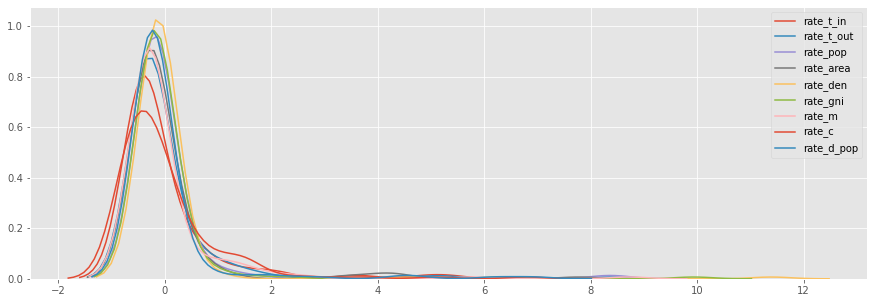

In [64]:
country_name = result_norm.iloc[:,0]
num_col = result_norm.columns[1:]
# print(num_col)
for col in num_col:
    x = pd.Series(result_norm[col], name=col)
#    sns.distplot(x)
    sns.kdeplot(x)

In [65]:
result_norm_T = result_norm.T
result_norm_T.shape

(10, 158)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DD83FC4390>,
      dtype=object)

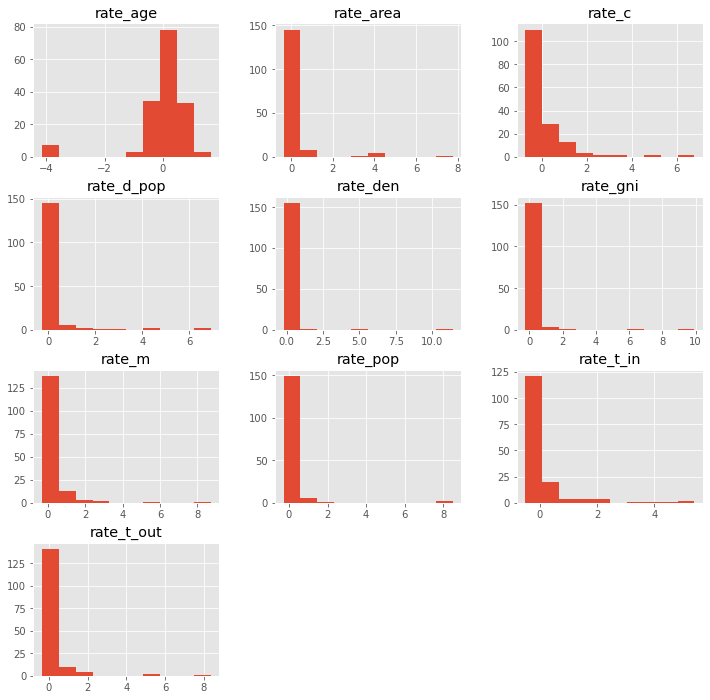

In [66]:
result_norm.hist(figsize=(12,12))

In [67]:
# найдем макс для подсчета весов:
num_d_max = result.iloc[:,-1].max()
num_d_max

0.4003378473704903

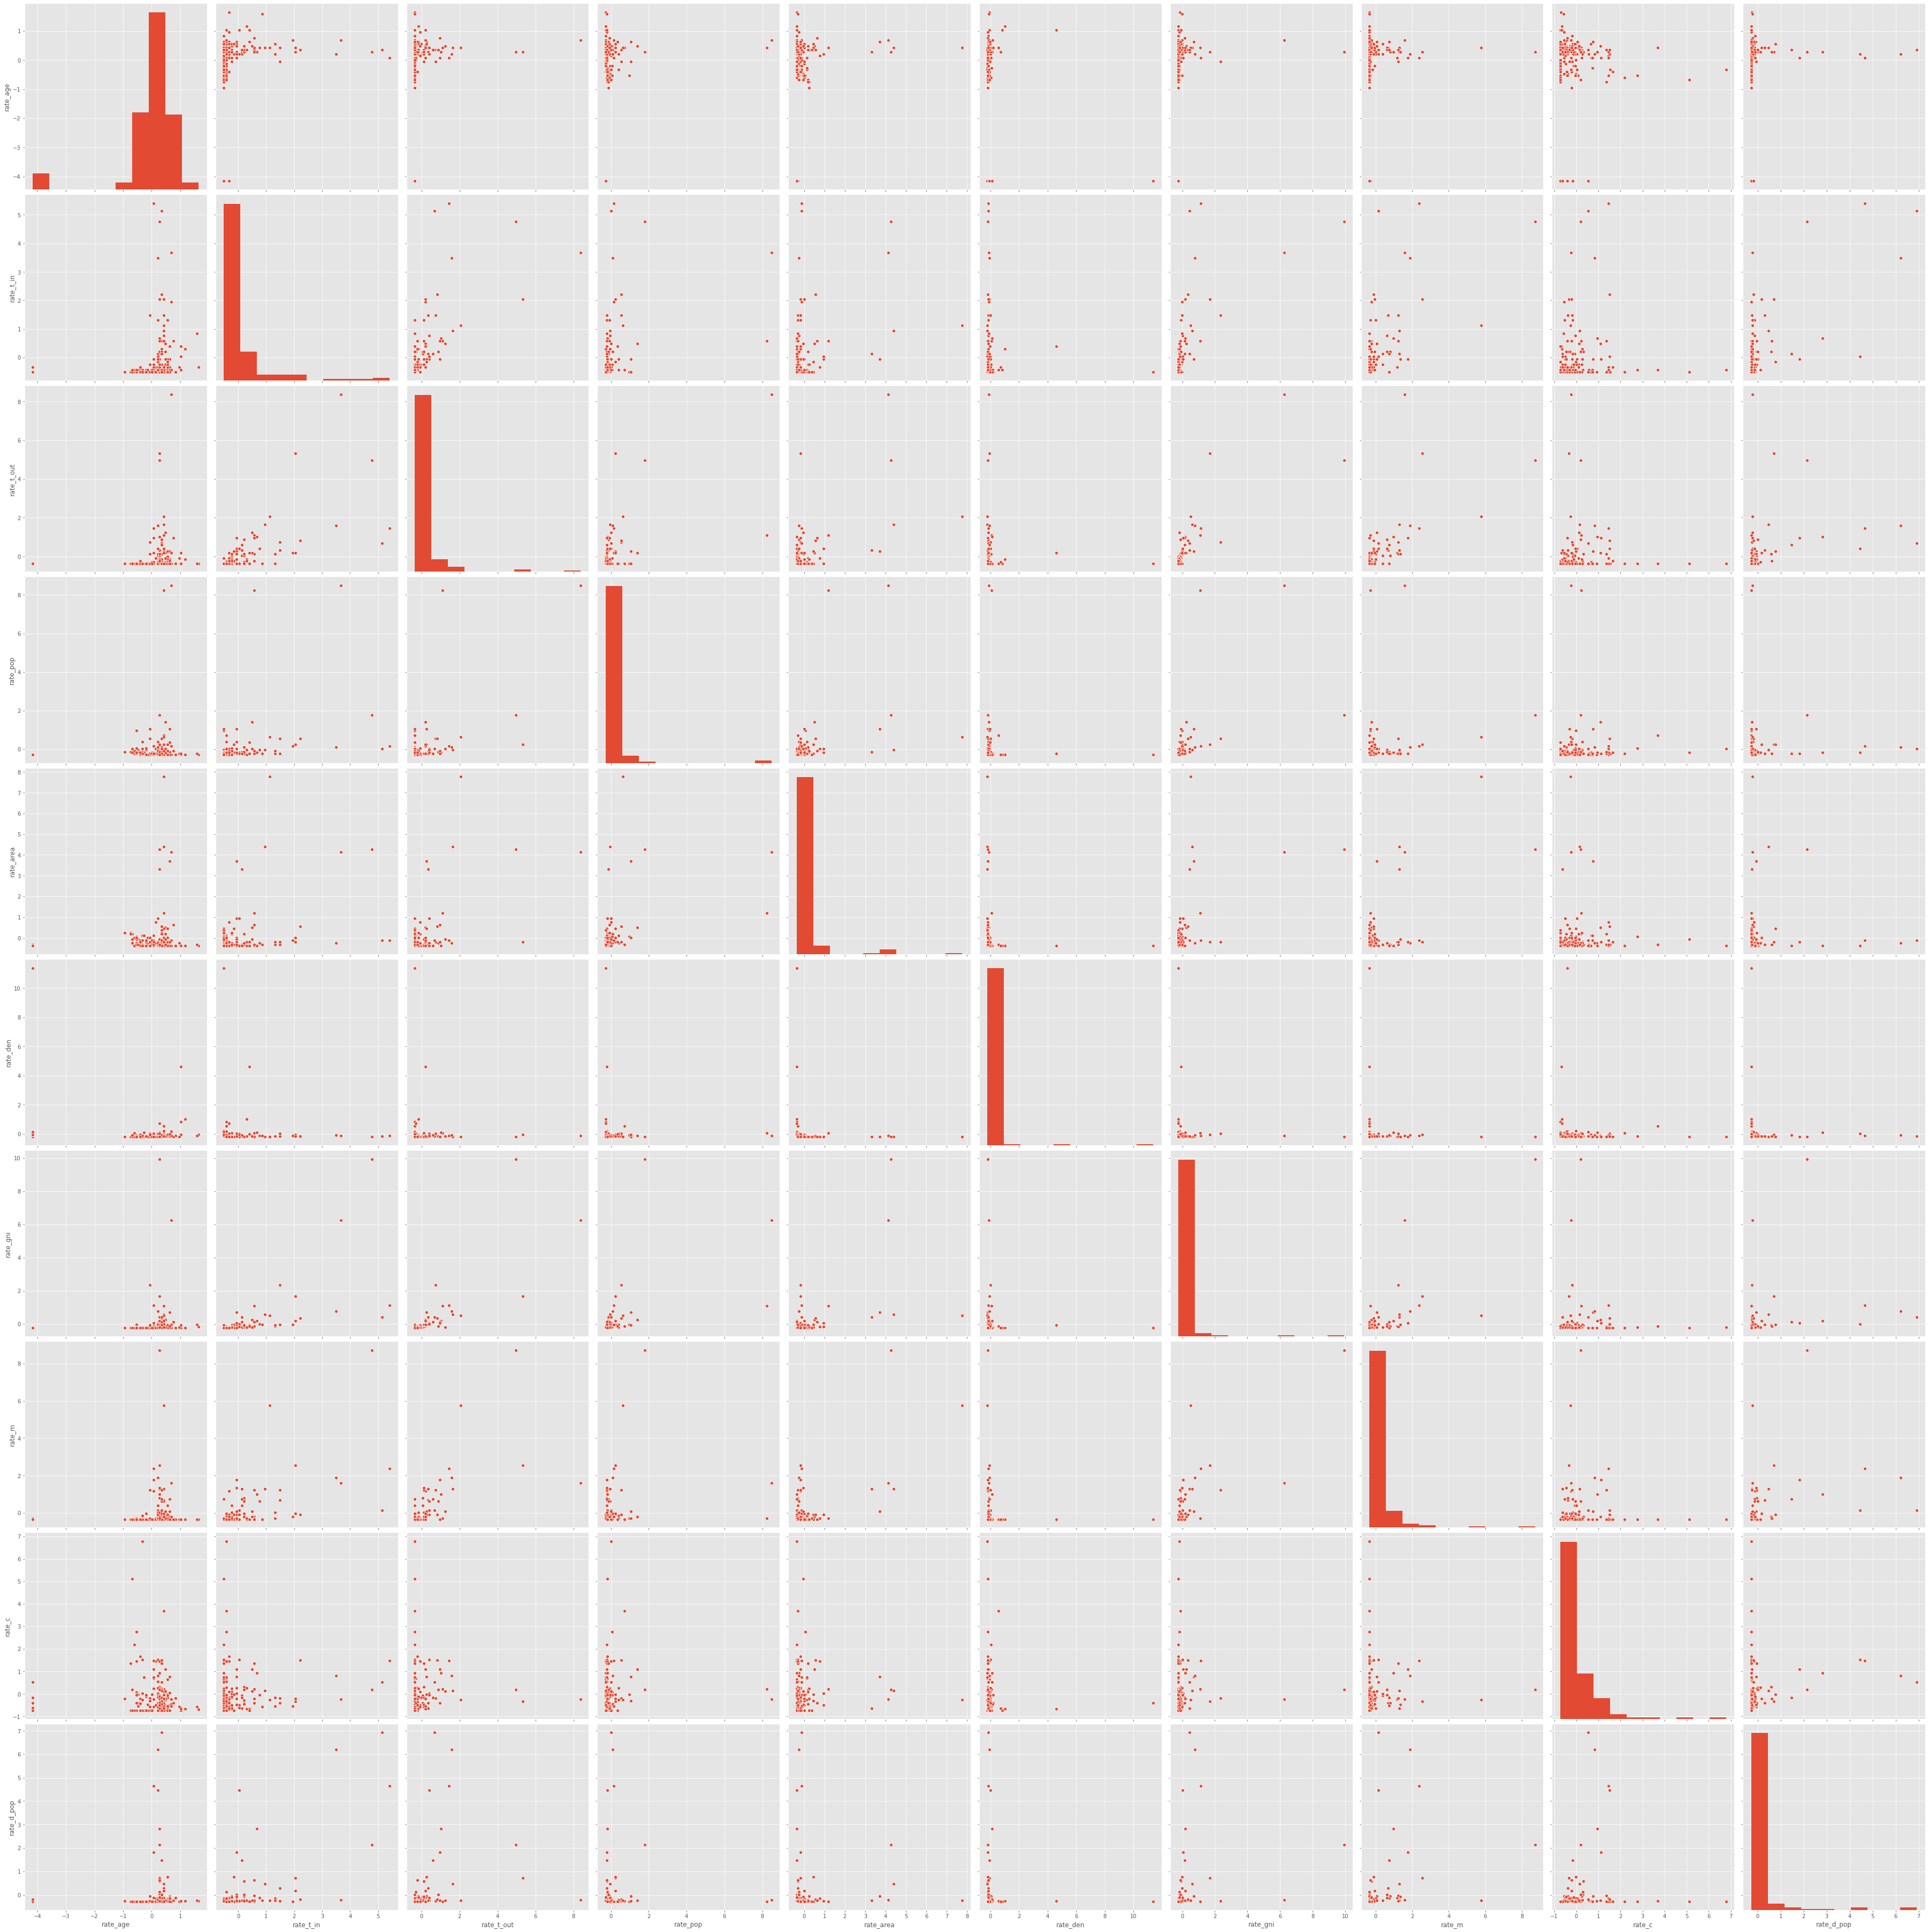

In [68]:
h = sns.pairplot(result_norm, hue=None, height=5, aspect=1)

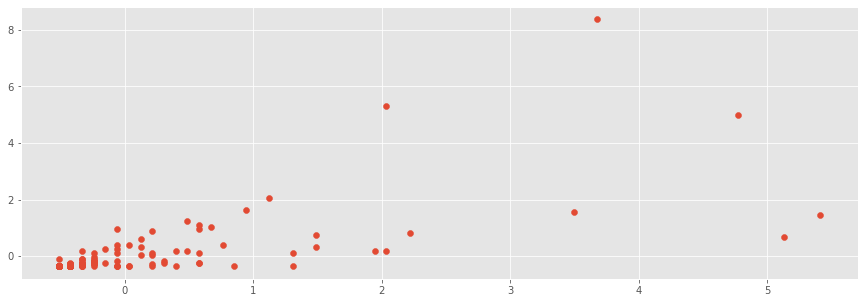

In [69]:
plt.scatter(result_norm['rate_t_in'], result_norm['rate_t_out'])

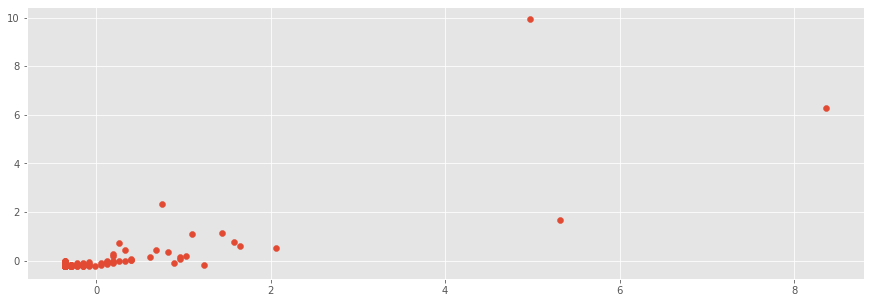

In [70]:
plt.scatter(result_norm['rate_t_out'], result_norm['rate_gni'])

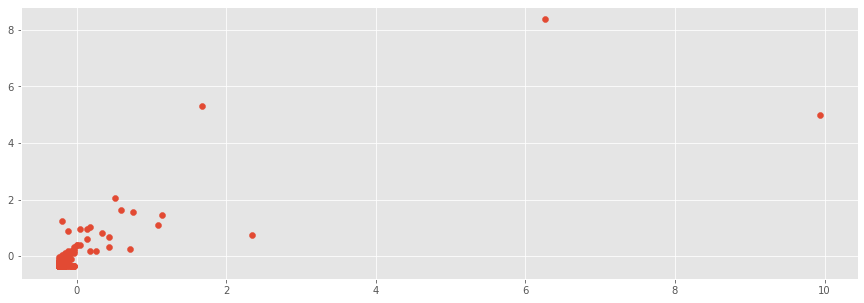

In [71]:
plt.scatter(result_norm['rate_gni'], result_norm['rate_t_out'])

In [72]:
result_norm.head()

,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,rate_d_pop
0,-0.468567,-0.513006,-0.358377,-0.039382,-0.057040,-0.162929,-0.239830,-0.335767,-0.019431,-0.270534
1,0.555883,-0.239787,-0.012267,-0.278700,-0.369965,-0.137839,-0.239830,-0.335767,-0.160342,-0.223105
2,0.146103,-0.330860,-0.081489,0.008482,0.756567,-0.188019,-0.156457,-0.275413,1.455156,-0.151962
3,-4.156588,-0.330860,-0.358377,-0.278700,-0.369965,-0.100203,-0.239830,-0.335767,-0.155060,-0.197019
4,-0.673457,-0.513006,-0.358377,-0.087245,0.193301,-0.188019,-0.198143,-0.335767,0.192466,-0.283814


In [73]:
result_agg_weight = result_norm
result_agg_country = result.pop('country')

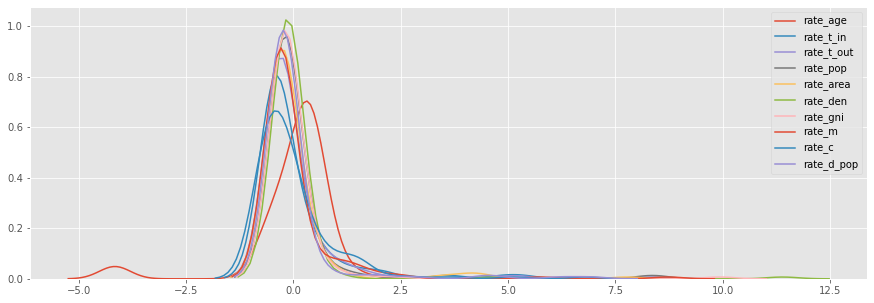

In [74]:
for column in result_agg_weight:
    x = pd.Series(result_agg_weight[column], name=column)
#    sns.distplot(x)
    sns.kdeplot(x)

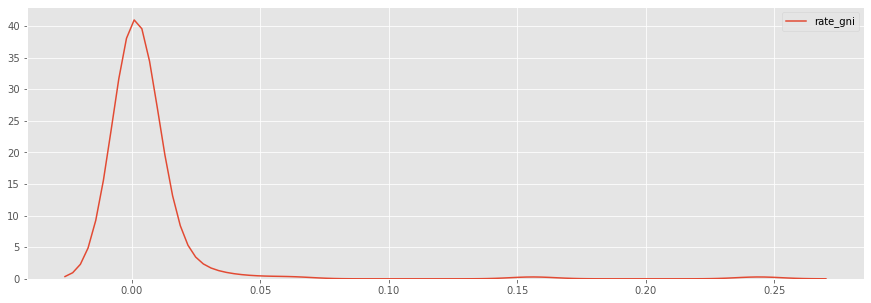

In [75]:
f = sns.kdeplot(pd.Series(result['rate_gni'], name='rate_gni'))

In [76]:
result.iloc[:,-1]

0      0.000790
1      0.003424
2      0.007374
3      0.004872
4      0.000053
         ...   
153    0.001448
154    0.000158
155    0.000000
156    0.000132
157    0.000132
Name: rate_d_pop, Length: 158, dtype: float64

In [77]:
data = result.sort_values(by = result.columns[-1], ascending=False).head(20)
# data = np.array(result.head(20))
type(data), data.shape

(pandas.core.frame.DataFrame, (20, 11))

In [78]:
# plt.plot(range(len(data)), (data), label='data')
# plt.plot(data=data[0,1:], label='data')
# sns.kdeplot(data[1:,:])
# columns = data.columns[9:-1]
# # print(columns, '&',data.iloc[0,8:], len(data))
# for i in range(0, len(data)):
#     x = pd.Series(data.iloc[i,9:])
# #    sns.distplot(x)
#     sns.kdeplot(x)

In [79]:
result.head()

,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,max_d,rate_d_pop
0,0.54,0.000,0.000,0.006,0.005,0.003,0.000,0.000,0.081081,36,0.000790
1,0.69,0.003,0.005,0.001,0.000,0.005,0.000,0.000,0.065000,26,0.003424
2,0.63,0.002,0.004,0.007,0.018,0.001,0.002,0.001,0.249364,392,0.007374
3,0.00,0.002,0.000,0.001,0.000,0.008,0.000,0.000,0.065603,37,0.004872
4,0.51,0.000,0.000,0.005,0.009,0.001,0.001,0.000,0.105263,2,0.000053


In [80]:
result_norm.head()

,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,rate_d_pop
0,-0.468567,-0.513006,-0.358377,-0.039382,-0.057040,-0.162929,-0.239830,-0.335767,-0.019431,-0.270534
1,0.555883,-0.239787,-0.012267,-0.278700,-0.369965,-0.137839,-0.239830,-0.335767,-0.160342,-0.223105
2,0.146103,-0.330860,-0.081489,0.008482,0.756567,-0.188019,-0.156457,-0.275413,1.455156,-0.151962
3,-4.156588,-0.330860,-0.358377,-0.278700,-0.369965,-0.100203,-0.239830,-0.335767,-0.155060,-0.197019
4,-0.673457,-0.513006,-0.358377,-0.087245,0.193301,-0.188019,-0.198143,-0.335767,0.192466,-0.283814


In [81]:
result_finale_data.head()

,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,max_d,rate_d_pop
0,0.54,0.000,0.000,0.006,0.005,0.003,0.000,0.000,0.081081,36,0.000790
1,0.69,0.003,0.005,0.001,0.000,0.005,0.000,0.000,0.065000,26,0.003424
2,0.63,0.002,0.004,0.007,0.018,0.001,0.002,0.001,0.249364,392,0.007374
3,0.00,0.002,0.000,0.001,0.000,0.008,0.000,0.000,0.065603,37,0.004872
4,0.51,0.000,0.000,0.005,0.009,0.001,0.001,0.000,0.105263,2,0.000053


In [82]:
result_finale_data.sort_values(by = 'rate_d_pop', ascending=False).head()

,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,max_d,rate_d_pop
136,0.66,0.062,0.015,0.007,0.004,0.005,0.016,0.008,0.143584,21282,0.400338
71,0.64,0.044,0.028,0.009,0.002,0.010,0.024,0.037,0.176787,24648,0.360621
51,0.62,0.065,0.026,0.010,0.004,0.006,0.033,0.045,0.250780,20829,0.274271
15,0.64,0.006,0.011,0.003,0.000,0.018,0.006,0.008,0.256292,5998,0.263268
105,0.65,0.013,0.020,0.003,0.000,0.025,0.010,0.022,0.189972,3929,0.172454


In [83]:
result_finale_data.sort_values(by = 'rate_d_pop', ascending=False).head()

,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,max_d,rate_d_pop
136,0.66,0.062,0.015,0.007,0.004,0.005,0.016,0.008,0.143584,21282,0.400338
71,0.64,0.044,0.028,0.009,0.002,0.010,0.024,0.037,0.176787,24648,0.360621
51,0.62,0.065,0.026,0.010,0.004,0.006,0.033,0.045,0.250780,20829,0.274271
15,0.64,0.006,0.011,0.003,0.000,0.018,0.006,0.008,0.256292,5998,0.263268
105,0.65,0.013,0.020,0.003,0.000,0.025,0.010,0.022,0.189972,3929,0.172454


In [84]:
result_data[result_data.country =='Russia']

,country,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,rate_d_pop
122,Russia,0.67,0.018,0.035,0.02,0.13,0.0,0.018,0.101,0.052583,0.003002


In [85]:
result_finale_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 0 to 157
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rate_age    158 non-null    float64
 1   rate_t_in   158 non-null    float64
 2   rate_t_out  158 non-null    float64
 3   rate_pop    158 non-null    float64
 4   rate_area   158 non-null    float64
 5   rate_den    158 non-null    float64
 6   rate_gni    158 non-null    float64
 7   rate_m      158 non-null    float64
 8   rate_c      158 non-null    float64
 9   max_d       158 non-null    int64  
 10  rate_d_pop  158 non-null    float64
dtypes: float64(10), int64(1)
memory usage: 14.8 KB


In [86]:
correlations_data = result_norm.corr(method='pearson', min_periods=1)['rate_d_pop'].sort_values()
correlations_data

rate_den     -0.025916
rate_pop      0.021265
rate_area     0.041955
rate_age      0.071271
rate_c        0.182546
rate_gni      0.256547
rate_t_out    0.316748
rate_m        0.375970
rate_t_in     0.670616
rate_d_pop    1.000000
Name: rate_d_pop, dtype: float64

## Write to CSV dataset

In [87]:
result_data.to_csv('covid_cumulative_dataset_rates.csv')

In [88]:
dataset = pd.read_csv('covid_cumulative_dataset_rates.csv', index_col=0)
dataset.head()

,country,rate_age,rate_t_in,rate_t_out,rate_pop,rate_area,rate_den,rate_gni,rate_m,rate_c,rate_d_pop
0,Afghanistan,0.54,0.000,0.000,0.006,0.005,0.003,0.000,0.000,0.081081,0.000790
1,Albania,0.69,0.003,0.005,0.001,0.000,0.005,0.000,0.000,0.065000,0.003424
2,Algeria,0.63,0.002,0.004,0.007,0.018,0.001,0.002,0.001,0.249364,0.007374
3,Andorra,0.00,0.002,0.000,0.001,0.000,0.008,0.000,0.000,0.065603,0.004872
4,Angola,0.51,0.000,0.000,0.005,0.009,0.001,0.001,0.000,0.105263,0.000053


# ML

In [89]:
from sklearn import metrics
from sklearn.svm import SVC

In [90]:
dataset = pd.read_csv('covid_cumulative_dataset_rates.csv', index_col=0)

X = dataset.iloc[:,1:]
y = dataset.pop('country')

In [91]:
y

0      Afghanistan
1          Albania
2          Algeria
3          Andorra
4           Angola
          ...     
153        Uruguay
154     Uzbekistan
155        Vietnam
156         Zambia
157       Zimbabwe
Name: country, Length: 158, dtype: object

In [92]:
# fit a SVM model to the data
model = SVC()
model.fit(X, y)
print(model)
# make predictions
expected = y
predicted = model.predict(X)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
                          precision    recall  f1-score   support

             Afghanistan       1.00      1.00      1.00         1
                 Albania       1.00      1.00      1.00         1
                 Algeria       1.00      1.00      1.00         1
                 Andorra       1.00      1.00      1.00         1
                  Angola       1.00      1.00      1.00         1
     Antigua and Barbuda       1.00      1.00      1.00         1
               Argentina       1.00      1.00      1.00         1
                 Armenia       1.00      1.00      1.00         1
               Australia       1.00      1.00      1.00         1
                 Austria       1.00      1.00      1.00         1
              Azerbaija